In [1]:
#import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import warnings
from mlxtend.regressor import StackingRegressor

In [2]:
# Do not show warnings
warnings.filterwarnings("ignore")

In [3]:
#Load datasets with train and test sample
train_set = pd.read_csv('train.csv')
test_set= pd.read_csv('test.csv')
#store the the ID of test-set in a variable
test_Id=test_set['Id']
#check size of both datasets
print('Train dataset dimensions '+str(train_set.shape))
print('Test dataset dimensions '+str(test_set.shape))



Train dataset dimensions (1460, 81)
Test dataset dimensions (1459, 80)


In [4]:
#Drop variable 'Id' from  train and test set
train_set.drop("Id", axis = 1, inplace = True)
test_set.drop("Id", axis = 1, inplace = True)

### Data tidying

***

#### Explored outliers: removed outliers with 'GrLivArea' > 4.000 and 'SalePrice' < 300.000

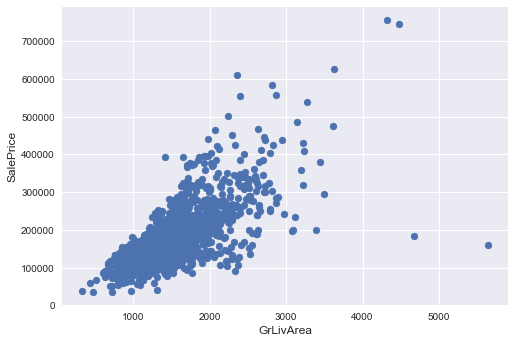

In [5]:
#Look for outliers in a fetature which it is thought to have big relevance
fig, ax = plt.subplots()
ax.scatter(x = train_set['GrLivArea'], y = train_set['SalePrice'])
plt.ylabel('SalePrice', fontsize=12)
plt.xlabel('GrLivArea', fontsize=12)
plt.show()

In [6]:
#Outliers are removed
train_set = train_set.drop(train_set[(train_set['GrLivArea']>4000) & (train_set['SalePrice']<300000)].index)


#### Normalization: Target variable('Sale Price') with Log Transformation

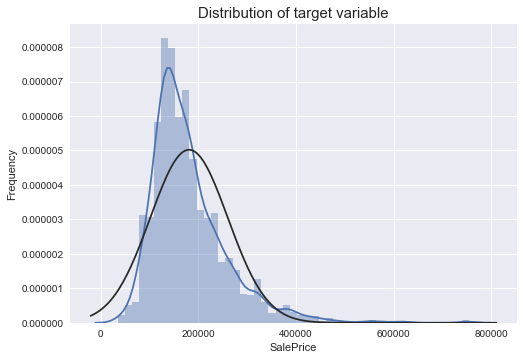

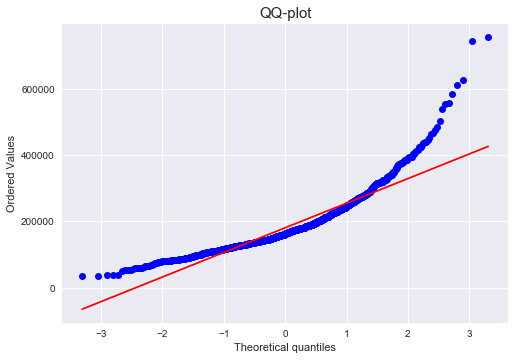

In [7]:
#Analysis of target variable (Y=SalePrice)
#Distribution plot of target distribution
sns.distplot(train_set['SalePrice'] , fit=stats.norm)
plt.ylabel('Frequency')
plt.title('Distribution of target variable',fontsize=15)
#QQ-plot
fig = plt.figure()
res = stats.probplot(train_set['SalePrice'], plot=plt)
plt.title('QQ-plot',fontsize=15)
plt.show()

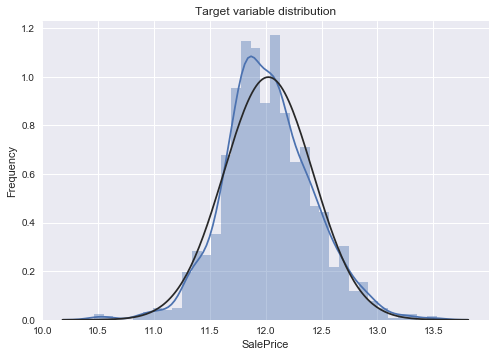

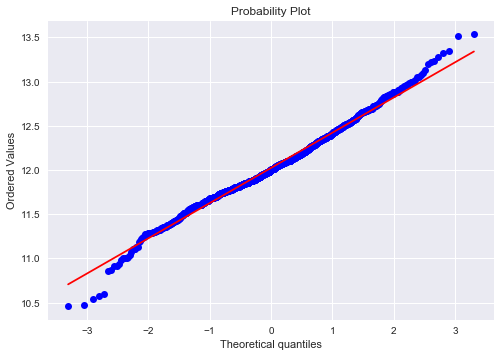

In [8]:
#Log transformation to target variable in order to make it more similar to a normal distribution
train_set["SalePrice"] = np.log1p(train_set["SalePrice"])
#Distribution plot after applying log transformation 
sns.distplot(train_set['SalePrice'] , fit=stats.norm);
plt.ylabel('Frequency')
plt.title('Target variable distribution')
#QQ-plot
fig = plt.figure()
res = stats.probplot(train_set['SalePrice'], plot=plt)
plt.show()

In [9]:
# lenghts of train set and test set are stored in variables
size_train_set=len(train_set)
size_test_set=len(test_set)
# concatenation of train and test data and removal of y_test
Y_train_set=train_set['SalePrice']
X_train_test= pd.concat((train_set, test_set)).reset_index(drop=True)
X_train_test.drop(['SalePrice'], axis=1, inplace=True)

#### Fill missing values. Depending on the feature, the missing value has been substituted by: 'None', 0, median of the feature, mode of the feature, category specified in documentation. Besides, 'Utilities' feature was dropped.

In [10]:
#Study of missing data 
X_train_test_null = (X_train_test.isnull().sum() / len(X_train_test)) * 100
X_train_test_null = X_train_test_null.drop(X_train_test_null[X_train_test_null == 0].index).sort_values(ascending=False)
miss_data_pct = pd.DataFrame({'Missing data %' :X_train_test_null})
#Dataframe with missing percentage of each variable
miss_data_pct

,Missing data %
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


In [11]:
#missing values(NA)--->means that there is not presence of that feature('None')
X_train_test["PoolQC"] = X_train_test["PoolQC"].fillna("None")
X_train_test["MiscFeature"] = X_train_test["MiscFeature"].fillna("None")
X_train_test["Alley"] = X_train_test["Alley"].fillna("None")
X_train_test["Fence"] = X_train_test["Fence"].fillna("None")
X_train_test["FireplaceQu"] = X_train_test["FireplaceQu"].fillna("None")
#No presence of garage
for i in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    X_train_test[i] = X_train_test[i].fillna('None')
# No garage------>variables equal to 0,'None'
for i in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    X_train_test[i] = X_train_test[i].fillna('None')
for i in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    X_train_test[i] = X_train_test[i].fillna(0)
# NA is not presence of basement
for i in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    X_train_test[i] = X_train_test[i].fillna(0)
#NA probably means there is no presence and hence area is o
X_train_test["MasVnrType"] = X_train_test["MasVnrType"].fillna("None")
X_train_test["MasVnrArea"] = X_train_test["MasVnrArea"].fillna(0)
#complete with most common values (mode)
for i in ['MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual','Exterior1st','Exterior2nd','Utilities']:
    X_train_test[i] = X_train_test[i].fillna(X_train_test[i].mode()[0])
# specific cases
#specified in documentation:Functional=NA --->'Functional'='Typ'
X_train_test["Functional"] = X_train_test["Functional"].fillna("Typ")
#read online--> best choice group by neighbhborhood and fill in missing value by the median LotFrontage of all the neighborhood
X_train_test["LotFrontage"] = X_train_test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
#read online--> do not produce difference
X_train_test= X_train_test.drop(['Utilities'], axis=1)
#re-check of missing values
missing_values = (X_train_test.isnull().sum() / len(X_train_test)) * 100
missing_values = missing_values.drop(missing_values[missing_values == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :missing_values})
missing_data

,Missing Ratio


## Feature engeneering

### Label Encoding

In [12]:
#Converting numerical variables which can be seen as categorical
X_train_test['OverallCond']=X_train_test['OverallCond'].astype(str)
X_train_test['YrSold'] = X_train_test['YrSold'].astype(str)
X_train_test['MSSubClass'] = X_train_test['MSSubClass'].apply(str)
#Label encoding of categorical variables using LabelEncoder()
#list with categorical variables 
cat_var = ['BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'Street', 'Alley', 
'CentralAir', 'MSSubClass', 'OverallCond', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'LandSlope','YrSold']
for i in cat_var:
    label_encoder = LabelEncoder() 
    label_encoder.fit(list(X_train_test[i].values)) 
    X_train_test[i] = label_encoder.transform(list(X_train_test[i].values))

In [13]:
#Including new feature
# Adding total sqfootage featuere 
X_train_test['TotalSF'] = X_train_test['TotalBsmtSF'] + X_train_test['1stFlrSF'] + X_train_test['2ndFlrSF']

#### Normalization: Box-cox transformation with alpha = 0.15 to variables with skewness > 0.75

In [14]:
#Numerical variables of the set
num_var = X_train_test.dtypes[X_train_test.dtypes != "object"].index
# Computation of skewness for each varaible
skewness_var = X_train_test[num_var].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
#Dataframe with most skewed--10 variables
skewness_df = pd.DataFrame({'Skewness' :skewness_var})
skewness_df.head(10)

,Skewness
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [15]:
#Box-cox transformation to variables with skewness bigger than 0.75
skewness_df = skewness_df[abs(skewness_df) > 0.75]
to_trans_var = skewness_df.index
for i in to_trans_var:
    X_train_test[i] = boxcox1p(X_train_test[i], 0.15)


#### Getting dummy variables for categorical features

In [16]:
#dummy varibles used for encoding--->equivalent to One Hot Encoding
X_train_test1 = pd.get_dummies(X_train_test)

In [17]:
#save preprocessed training and test set in different variables
prepro_train_set = X_train_test1[:size_train_set]
prepro_test_set = X_train_test1[size_train_set:]

In [18]:
prepro_train_set.to_csv('newtrainhot.csv', sep=',', encoding='utf-8')

## Modelization +Training:

#### It has been used a 5-fold cross validation with shuffle

In [19]:
#creation of cross validation function in order to evaluate the model---->score:RMSE
#n_folds = 5
def RMSE_CrossValidation(model,train,y_train):
    #It is computed the mean of the 5-fold crossvalidation using as score the RSME
    #model: model which is evaluated using k-fold
    #train:set of values to train model
    #y_train:predictions of values of train set
    n_folds = 5
    k_f = KFold(n_folds, shuffle=True, random_state=43).get_n_splits(train.values)
    return( np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = k_f)) )

### Models:


* ** Lasso + Robust Scaler **

In [20]:
#Try different alpha+ lasso with robust scaler to avoid presence of outliers
alpha=[0.00005,0.0005,0.001,0.0015,0.002]
BEST_={}
for i in alpha:
    lasso_model = make_pipeline(RobustScaler(), Lasso(alpha =i, random_state=5))
    print('alpha :'+str(i),(RMSE_CrossValidation(lasso_model,prepro_train_set,Y_train_set)).mean())
    BEST_['alpha:' +str(i)]=(RMSE_CrossValidation(lasso_model,prepro_train_set,Y_train_set)).mean()
sorted_BEST_ = sorted(BEST_.items(), key=lambda kv: kv[1])
print('The best parameters :'+str(sorted_BEST_[0]))

alpha :5e-05 0.12011012361666659
alpha :0.0005 0.11180121977066956
alpha :0.001 0.11368262309392226
alpha :0.0015 0.11689162202464627
alpha :0.002 0.11923881046338407
The best parameters :('alpha:0.0005', 0.11180121977066956)


* **Elastic Net Regression + Robust Scaler**

In [21]:
#Robust scaler included to Elastic Net model to  avoid presence of outliers
#Try different alpha+ Elastic Net with robust scaler to avoid presence of outliers
alpha=[0.00005,0.0005,0.001,0.0015,0.002]
l1_ratio=[0.3,0.5,0.7,0.9]
BEST_={}
for i in alpha:
    for j in l1_ratio:
        ENet_model = make_pipeline(RobustScaler(), ElasticNet(alpha=i, l1_ratio=j, random_state=6))    
        print('alpha :'+str(i),'l_ratio: '+str(j) ,(RMSE_CrossValidation(ENet_model,prepro_train_set,Y_train_set)).mean())
        BEST_['alpha:' +str(i)+' l_ratio: '+str(j)]=(RMSE_CrossValidation(ENet_model,prepro_train_set,Y_train_set)).mean()
sorted_BEST_ = sorted(BEST_.items(), key=lambda kv: kv[1])
print('The best parameters :'+str(sorted_BEST_[0]))

alpha :5e-05 l_ratio: 0.3 0.12293673652027386
alpha :5e-05 l_ratio: 0.5 0.12207395000600345
alpha :5e-05 l_ratio: 0.7 0.12125578783967299
alpha :5e-05 l_ratio: 0.9 0.12047232649504178
alpha :0.0005 l_ratio: 0.3 0.11461944420825354
alpha :0.0005 l_ratio: 0.5 0.11304768366088347
alpha :0.0005 l_ratio: 0.7 0.11222680850641129
alpha :0.0005 l_ratio: 0.9 0.1118645303455166
alpha :0.001 l_ratio: 0.3 0.11250502220401856
alpha :0.001 l_ratio: 0.5 0.11196952927880721
alpha :0.001 l_ratio: 0.7 0.11246026199356111
alpha :0.001 l_ratio: 0.9 0.11317235815549773
alpha :0.0015 l_ratio: 0.3 0.11214548906311164
alpha :0.0015 l_ratio: 0.5 0.11280932204827432
alpha :0.0015 l_ratio: 0.7 0.11417066782709966
alpha :0.0015 l_ratio: 0.9 0.11602084288702175
alpha :0.002 l_ratio: 0.3 0.11253487303921972
alpha :0.002 l_ratio: 0.5 0.11408225333292032
alpha :0.002 l_ratio: 0.7 0.11645772211113611
alpha :0.002 l_ratio: 0.9 0.1184818765929521
The best parameters :('alpha:0.0005 l_ratio: 0.9', 0.1118645303455166)


* **Kernel Ridge Regression**:

In [22]:
# Kernel Rigdge Regression model with different alpha models
alpha=[0.3,0.4,0.5,0.6]
BEST_={}
for i in alpha:
    KRR_model = KernelRidge(alpha=i, kernel='polynomial', degree=2, coef0=2.5)
    print('alpha :'+str(i) ,(RMSE_CrossValidation(KRR_model,prepro_train_set,Y_train_set)).mean())
    BEST_['alpha:' +str(i)]=(RMSE_CrossValidation(KRR_model,prepro_train_set,Y_train_set)).mean()

sorted_BEST_ = sorted(BEST_.items(), key=lambda kv: kv[1])
print('The best parameters :'+str(sorted_BEST_[0]))

alpha :0.3 0.11791515898662215
alpha :0.4 0.11705206059117057
alpha :0.5 0.11653132743152335
alpha :0.6 0.11621062108206578
The best parameters :('alpha:0.6', 0.11621062108206578)


* **Gradient Boosting Regression + Huber loss**

In [23]:
#Gradient Boosting Regression model with different number of estimators
n_est=[2000,3000,4000]
BEST_={}
for i in n_est:
    GBoostR_model= GradientBoostingRegressor(n_estimators=i, learning_rate=0.05,
                                       max_depth=4, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =8)
    
    print('n_est :'+str(i) ,(RMSE_CrossValidation(GBoostR_model,prepro_train_set,Y_train_set)).mean())
    BEST_['n_est:' +str(i)]=(RMSE_CrossValidation(GBoostR_model,prepro_train_set,Y_train_set)).mean()
    
sorted_BEST_ = sorted(BEST_.items(), key=lambda kv: kv[1])
print('The best parameters :'+str(sorted_BEST_[0]))

n_est :2000 0.11794616152084594
n_est :3000 0.11858626291815706
n_est :4000 0.11905512308151008
The best parameters :('n_est:2000', 0.11794616152084594)


* **XGBoost**

In [24]:
# XGBoost Regression model for several parameters of alpha and lambda
alpha_=[0.464,0.654]
lambda_=[0.723,0.8571]
BEST_={}
for i in lambda_:
    for j in alpha_:
        XGB_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                     learning_rate=0.05, max_depth=3, 
                                     min_child_weight=1.7817, n_estimators=2200,
                                     reg_alpha=j, reg_lambda=i,
                                     subsample=0.5213, silent=1,
                                     random_state =12, nthread = -1)
        print('lambda :'+str(i),'alpha:'+str(j) ,(RMSE_CrossValidation(XGB_model,prepro_train_set,Y_train_set)).mean())
        BEST_['lambda :' +str(i)+'alpha:'+str(j)]=(RMSE_CrossValidation(XGB_model,prepro_train_set,Y_train_set)).mean()

sorted_BEST_ = sorted(BEST_.items(), key=lambda kv: kv[1])
print('The best parameters :'+str(sorted_BEST_[0]))

lambda :0.723 alpha:0.464 0.11672105224528169
lambda :0.723 alpha:0.654 0.11786502900307808
lambda :0.8571 alpha:0.464 0.11639218648057006
lambda :0.8571 alpha:0.654 0.11751173175003324
The best parameters :('lambda :0.8571alpha:0.464', 0.11639218648057006)


* **LightGBM**

In [25]:
#LigthGBM Regression model for different number of iterations
n_est=[650,720,765,780]
BEST_={}
for i in n_est:
    LGB_model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                  learning_rate=0.05, n_estimators=i,
                                  max_bin = 55, bagging_fraction = 0.8,
                                  bagging_freq = 5, feature_fraction = 0.2319,
                                  feature_fraction_seed=9, bagging_seed=9,
                                  min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
    print('n_est :'+str(i) ,(RMSE_CrossValidation(LGB_model,prepro_train_set,Y_train_set)).mean())
    BEST_['n_est :' +str(i)]=(RMSE_CrossValidation(LGB_model,prepro_train_set,Y_train_set)).mean()

sorted_BEST_ = sorted(BEST_.items(), key=lambda kv: kv[1])
print('The best parameters :'+str(sorted_BEST_[0]))

n_est :650 0.11568787378934012
n_est :720 0.11563344269046258
n_est :765 0.11557430514552561
n_est :780 0.1156374786886023
The best parameters :('n_est :765', 0.11557430514552561)


#### Base models scores

In [26]:
models_=[lasso_model,ENet_model,KRR_model,GBoostR_model,XGB_model,LGB_model]
models_name=['Lasso','Elastic Net','Kernel Ridge Regression','Gradient Boosting Regression','XGBoosting','LightGBM']
for i in range(len(models_)):
    print(models_name[i],(RMSE_CrossValidation(models_[i],prepro_train_set,Y_train_set)).mean())


Lasso 0.11923881046338407
Elastic Net 0.1184818765929521
Kernel Ridge Regression 0.11621062108206578
Gradient Boosting Regression 0.11905512308151008
XGBoosting 0.11751173175003324
LightGBM 0.1156374786886023


In [27]:
#lasso model
lasso_model = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=5))
#Elastic Net model
ENet_model = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=6))    
#Kernel Ridge Regression
KRR_model = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
#Gradient Boosting Regression
GBoostR_model= GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                       max_depth=4, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =8)
    
#XGB Regression Model
XGB_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                     learning_rate=0.05, max_depth=3, 
                                     min_child_weight=1.7817, n_estimators=2000,
                                     reg_alpha=0.464, reg_lambda=0.851,
                                     subsample=0.5213, silent=1,
                                     random_state =12, nthread = -1)
#Light model
LGB_model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                  learning_rate=0.05, n_estimators=720,
                                  max_bin = 55, bagging_fraction = 0.8,
                                  bagging_freq = 5, feature_fraction = 0.2319,
                                  feature_fraction_seed=9, bagging_seed=9,
                                  min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Stacking model

In [28]:
stack = StackingRegressor(regressors =[lasso_model,ENet_model,KRR_model,XGB_model,LGB_model], meta_regressor=GBoostR_model )

In [29]:
def RSME_evaluation(y, y_predicted):
    #Obtains the RSME using the pedicted values by the model
    #y:real y-values
    #y_predicted: y predicted values
    return np.sqrt(mean_squared_error(y, y_predicted))

#### Final Training and Prediction

In [30]:
models_=[lasso_model,ENet_model,KRR_model,GBoostR_model,XGB_model,LGB_model,stack]
models_name=['Lasso','Elastic Net','Kernel Ridge Regression','Gradient Boosting Regression','XGBoosting','LightGBM','stack']
models_result={}
for i in range(len(models_)):
    models_[i].fit(prepro_train_set.values, Y_train_set)
    model_train_pred = models_[i].predict(prepro_train_set.values)
    model_pred = np.expm1(models_[i].predict(prepro_test_set.values))
    models_result[models_name[i]]=model_pred
    print(models_name[i],RSME_evaluation(Y_train_set,model_train_pred))


Lasso 0.10139747407352856
Elastic Net 0.1009058110328776
Kernel Ridge Regression 0.08503747717502816
Gradient Boosting Regression 0.05628430876661767
XGBoosting 0.07844212558838876
LightGBM 0.07267742754358877
stack 0.04994280355829636


#### Weight average of all the models

In [31]:
final_pred=(0.14*models_result['stack']+
    0.14*models_result['Lasso']+
          0.14*models_result['Elastic Net']+
          0.14*models_result['Kernel Ridge Regression']+
          0.16*models_result['Gradient Boosting Regression']+
          0.14*models_result['XGBoosting']+
          0.14*models_result['LightGBM'])

## Submission

In [32]:
#test_ID = test['Id']

submission = pd.DataFrame()
submission['Id'] = test_Id
submission['SalePrice'] = final_pred
submission.to_csv('submission_fancy.csv',index=False)